In [ ]:
# 10개으 mask와 original

In [6]:
import cv2
import collections
import time 
from tqdm import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import copy
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import nibabel as nib
import subprocess
import matplotlib.pyplot as plt
import cv2
import pydicom
from PIL import Image
import time
import sys
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor

import segmentation_models_pytorch as smp
import os

import re
def export_num(string):
    find_num = re.compile('[0-9.]+')
    number = find_num.findall(string[-10:-4])
    return int(number[0])

seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


PATH = "../../../cpt_data/ct_new/"



images_paths = []

for person_id in os.listdir(PATH + f"1.원본/"):
    original_list = os.listdir(PATH + f"1.원본/{person_id}")
    original_path = pd.DataFrame(
                                {"1.원본" : original_list},
                                index = list(map(export_num, original_list))
                               ).sort_index()
    original_max = original_path.index.max()
    
    # 근욱을 기준으로 생성
    musle_list = os.listdir(PATH + f"2.근육/tif/{person_id}")
    file_names = pd.DataFrame({"2.근육" : musle_list},
                                index = list(map(export_num, musle_list))
                               ).sort_index()
    file_names["2.근육"] = PATH + f"2.근육/tif/{person_id}/" +\
                            file_names["2.근육"]
    musle_min = file_names.index.min()
    musle_max = file_names.index.max()
    
    # 내장지방, 피하지방 추가하기 
    for name in ['3.내장지방', '4.피하지방']:
        part_list = os.listdir(PATH + f"{name}/tif/{person_id}")
        part_paths = pd.DataFrame( {name : part_list},
                                    index = list(map(export_num, part_list))
                                   ).sort_index()
        file_names[name] = part_paths.loc[musle_min:musle_max+1]
        file_names[name] = PATH + f"{name}/tif/{person_id}/" +\
                            file_names[name]
    
    
    # 잘못된 원본 path 변환하기
    original_path.index = original_max - original_path.index
    file_names["1.원본"] = original_path.loc[musle_max:musle_min-1]
    file_names["1.원본"] = PATH + f"1.원본/{person_id}/" +\
                            file_names["1.원본"]
    
    file_names["person_idx"] = person_id
    file_names = file_names.reset_index()
    file_names = file_names.rename({'index':'loc_index'}, axis = 1)
    file_names = file_names.set_index(['person_idx', 'loc_index'])
    file_names = file_names[['1.원본', '2.근육','3.내장지방','4.피하지방']]
    images_paths.append(file_names)
    
    
images_paths =  pd.concat(images_paths)
images_paths = images_paths.reset_index()
images_paths

,person_idx,loc_index,1.원본,2.근육,3.내장지방,4.피하지방
0,00003552,70,../../../cpt_data/ct_new/1.원본/00003552/0000355...,../../../cpt_data/ct_new/2.근육/tif/00003552/000...,../../../cpt_data/ct_new/3.내장지방/tif/00003552/0...,../../../cpt_data/ct_new/4.피하지방/tif/00003552/0...
1,00003552,71,../../../cpt_data/ct_new/1.원본/00003552/0000355...,../../../cpt_data/ct_new/2.근육/tif/00003552/000...,../../../cpt_data/ct_new/3.내장지방/tif/00003552/0...,../../../cpt_data/ct_new/4.피하지방/tif/00003552/0...
2,00003552,72,../../../cpt_data/ct_new/1.원본/00003552/0000355...,../../../cpt_data/ct_new/2.근육/tif/00003552/000...,../../../cpt_data/ct_new/3.내장지방/tif/00003552/0...,../../../cpt_data/ct_new/4.피하지방/tif/00003552/0...
3,00003552,73,../../../cpt_data/ct_new/1.원본/00003552/0000355...,../../../cpt_data/ct_new/2.근육/tif/00003552/000...,../../../cpt_data/ct_new/3.내장지방/tif/00003552/0...,../../../cpt_data/ct_new/4.피하지방/tif/00003552/0...
4,00003552,74,../../../cpt_data/ct_new/1.원본/00003552/0000355...,../../../cpt_data/ct_new/2.근육/tif/00003552/000...,../../../cpt_data/ct_new/3.내장지방/tif/00003552/0...,../../../cpt_data/ct_new/4.피하지방/tif/00003552/0...
...,...,...,...,...,...,...
2455,00004237,116,../../../cpt_data/ct_new/1.원본/00004237/0000423...,../../../cpt_data/ct_new/2.근육/tif/00004237/000...,../../../cpt_data/ct_new/3.내장지방/tif/00004237/0...,../../../cpt_data/ct_new/4.피하지방/tif/00004237/0...
2456,00004237,117,../../../cpt_data/ct_new/1.원본/00004237/0000423...,../../../cpt_data/ct_new/2.근육/tif/00004237/000...,../../../cpt_data/ct_new/3.내장지방/tif/00004237/0...,../../../cpt_data/ct_new/4.피하지방/tif/00004237/0...
2457,00004237,118,../../../cpt_data/ct_new/1.원본/00004237/0000423...,../../../cpt_data/ct_new/2.근육/tif/00004237/000...,../../../cpt_data/ct_new/3.내장지방/tif/00004237/0...,../../../cpt_data/ct_new/4.피하지방/tif/00004237/0...
2458,00004237,119,../../../cpt_data/ct_new/1.원본/00004237/0000423...,../../../cpt_data/ct_new/2.근육/tif/00004237/000...,../../../cpt_data/ct_new/3.내장지방/tif/00004237/0...,../../../cpt_data/ct_new/4.피하지방/tif/00004237/0...


In [45]:
for index in range(len(images_paths)):
    if index > 10:
        break
    index = np.random.randint(len(images_paths))   
    print(len(images_paths.loc[index, '1.원본']))
    if len(images_paths.loc[index, '1.원본']) != 65:
        continue
        
    musle = np.array(Image.open(images_paths.loc[index, '2.근육'])).astype(np.uint8) * 255
    visceral = np.array(Image.open(images_paths.loc[index, '3.내장지방'])).astype(np.uint8) * 255
    subcutaneous = np.array(Image.open(images_paths.loc[index, '4.피하지방'])).astype(np.uint8) * 255
    
    subprocess.call(["cp",
                 images_paths.loc[index, '1.원본'],
                 f"sample_png/원본/{images_paths.loc[index, '1.원본'][-26:-4]}.dcm"] ,shell = False)
    cv2.imwrite(f"sample_png/근육/{images_paths.loc[index, '1.원본'][-26:-4]}.png", musle)
    cv2.imwrite(f"sample_png/내장지방/{images_paths.loc[index, '1.원본'][-26:-4]}.png", visceral)
    cv2.imwrite(f"sample_png/피하지방/{images_paths.loc[index, '1.원본'][-26:-4]}.png", subcutaneous)    

65
65
65
65
65
65
65
65
65
65
65


In [33]:
len("00003399_converted_148.dcm")

26

In [41]:
images_paths.loc[index, '1.원본'][-26:-4]

'00003399_converted_148'

In [37]:
for index in range(len(images_paths.loc[index, '1.원본'])):
    print()
    if index > 10:
        break

65

In [49]:
index = 1227
image = np.array(pydicom.dcmread(f"sample_png/원본/00003580_converted_147.dcm").pixel_array)
image[(image<=0)] = 0
image[(image>200)&(image<850)] = 200
image[(image>=850)] = image[(image>=850)] - 650
image[(image>=500)] = 500
image = image/2

In [50]:
musle = np.array(Image.open(f"sample_png/근육/00003580_converted_147.png")).astype(np.uint8) * 255

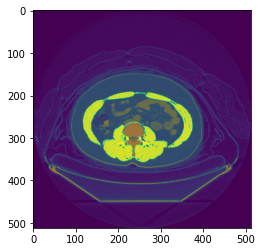

In [51]:
plt.imshow(musle)
plt.imshow(image, alpha = 0.5)
plt.show()